# Choosing the distance thresholds for tracking
We set the travel distance threshold based on observed displacement distances from buoys in marginal ice zones. We accessed Level 1 buoy data from the IABP, then performed basic QC by checking for non-physical speeds and duplicated data. We selected subsets of the buoy data from April to September from regions with SIC between 15 and 80%, then computed the displacement distance at time lags of 1 hr to 4 days. From the distributions of displacement distances, we can fit a curve to estimate the 99th percentile of the data. 

In [1]:
import io
import numpy as np
import os
import pandas as pd
import pyproj
import sys
import xarray as xr
import ultraplot as pplt
import warnings
warnings.simplefilter(category=FutureWarning, action="ignore")

Quality control steps
1. Filter dates: Only looking at April to September
2. Filter SIC: Only looking at 15 to 80% SIC, so if insufficient in range, skip
3. Filter expeditions: only take a few from the clustered data points
4. Quality control using `icedrift`
5. Save the trajectories we're using.

In [313]:
import ultraplot as pplt
save_loc = '../data/iabp_miz_data/'
buoy_data = {}
for year in range(2003, 2023):
    data = pd.read_csv(save_loc + 'iabp_data_{y}.csv'.format(y=year), parse_dates=['datetime'])
    for buoy_id, buoy_df in data.groupby('buoy_id'):
        miz = buoy_df.sic_monthly.between(0.15, 0.80)
        times = buoy_df.datetime.dt.month.between(4, 9)
        if sum(miz & times) > 50:
            buoy_data[str(year) + '_' + str(buoy_id)] = buoy_df.loc[miz & times]

In [350]:
print("Number of individual buoys: ", len(buoy_data))

Number of individual buoys:  672


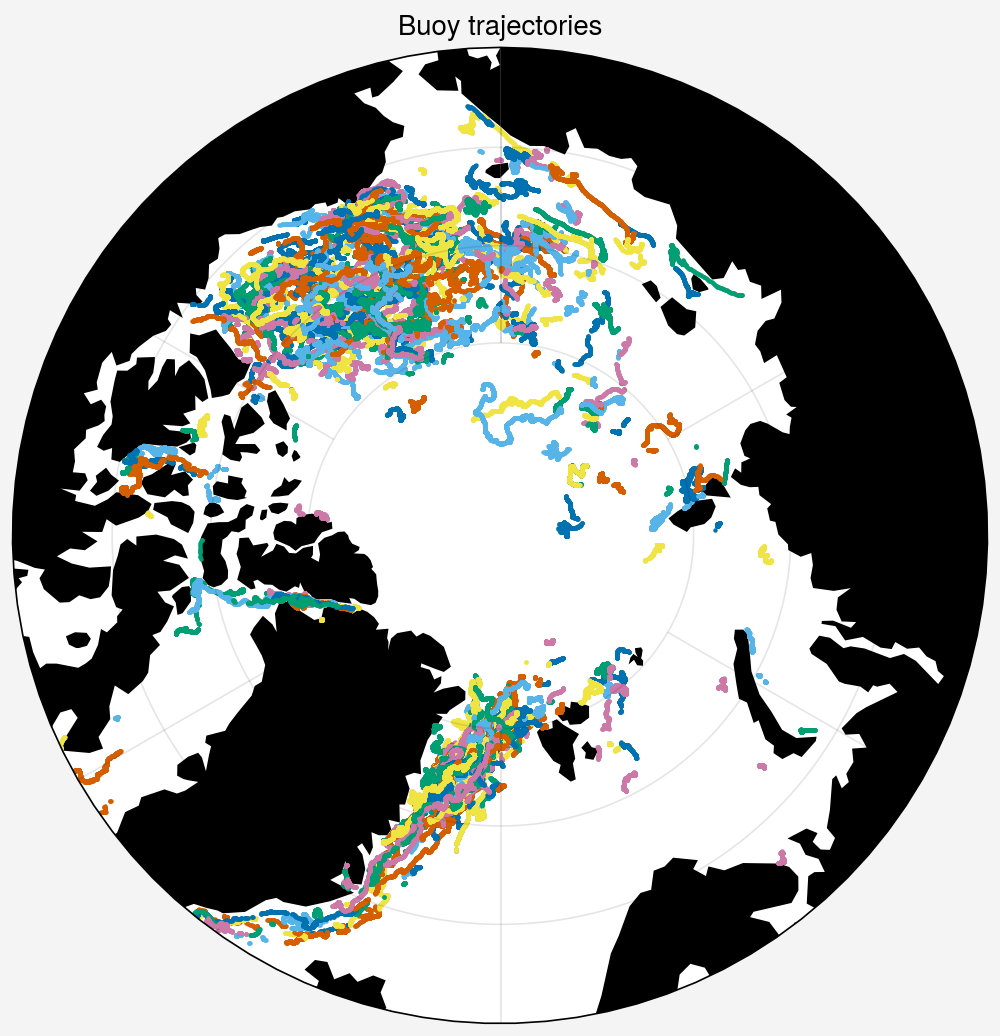

In [351]:
fig, ax = pplt.subplots(proj='npstere', width=5)
ax.format(boundinglat=65, land=True)
for buoy_id in buoy_data:
    ax.scatter(buoy_data[buoy_id].longitude,
            buoy_data[buoy_id].latitude, ms=1)
ax.format(title="Buoy trajectories")

# Notes on the dataset
1. Most of the data is in either the Fram Strait or in the Beaufort Gyre
2. The data are unevenly sampled in time.

In [352]:
year_counts = {}
year_data_points = {}
for buoy in buoy_data:
    year = buoy.split('_')[0]
    if year not in year_counts:
        year_counts[year] = 0
        year_data_points[year] = 0
    year_counts[year] += 1
    year_data_points[year] += len(buoy_data[buoy])
pd.DataFrame({"buoys": pd.Series(year_counts),
              "data_points": pd.Series(year_data_points)})

,buoys,data_points
2004,1,108
2005,1,250
2006,1,74
2007,4,2565
2008,15,10340
2009,4,3385
2010,9,6541
2011,16,10488
2012,28,11863
2013,20,11350


In [35]:
import icedrift.interpolation as intrp

In [261]:
df.longitude.min()

np.float64(-179.98751)

In [44]:
buoy_data_interp = {}
for buoy_id in buoy_data:
    buoy_data_interp[buoy_id] = intrp.interpolate_buoy_track(buoy_data[buoy_id].set_index('datetime', drop=True), freq='1h')

In [173]:
g = pyproj.Geod(ellps='WGS84')

count = 0
results = {}
for buoy_id in buoy_data_interp: 
        df = buoy_data_interp[buoy_id]

        for hours in (1, 3, 6, 12, 24, 48, 72, 96):
            if hours not in results:
                results[hours] = []
            df_samp = df.resample('{t}h'.format(t=hours)).asfreq()
            fwd, bck, dist = g.inv(df_samp.longitude, df_samp.latitude, df_samp.shift(1).longitude, df_samp.shift(1).latitude)
            
            # dist = dist[~np.isnan(dist)]
            df_samp['distance'] = np.round(dist, 2)
            df_samp['dt'] = hours
            df_samp['buoy_id'] = buoy_id
            results[hours].append(df_samp)

In [332]:
g = pyproj.Geod(ellps='WGS84')

count = 0
results_bg = {}
results_fs = {}
for buoy_id in buoy_data_interp: 
        df = buoy_data_interp[buoy_id]
        for hours in (1, 3, 6, 12, 24, 48, 72, 96):
            if hours not in results_bg:
                results_bg[hours] = []
                results_fs[hours] = []

            in_fs = df.longitude.between(-45, 100)
            in_bg = df.longitude.between(-180, -120)

            if (sum(in_fs) > 10) | (sum(in_bg) > 10):
                df_samp = df.resample('{t}h'.format(t=hours)).asfreq()
                in_fs = df_samp.longitude.between(-45, 100)
                in_bg = df_samp.longitude.between(-180, -120)
                # fwd, bck, dist = g.inv(df_samp.longitude, df_samp.latitude, df_samp.shift(1).longitude, df_samp.shift(1).latitude)
                dist = np.sqrt((df_samp.x_stere.shift(-1) - df_samp.x_stere)**2 + (df_samp.y_stere.shift(-1) - df_samp.y_stere)**2)
                # dist = dist[~np.isnan(dist)]
                df_samp['distance'] = np.round(dist, 2)
                df_samp['dt'] = hours
                df_samp['buoy_id'] = buoy_id
                if sum(in_fs) > sum(in_bg):
                    results_fs[hours].append(df_samp.loc[in_fs])
                else:
                    results_bg[hours].append(df_samp.loc[in_bg])
                    

In [333]:
temp = []
for hour in results_fs:
    dfr = pd.concat(results_fs[hour]).dropna()

    dfh = pd.DataFrame({
              'mean': dfr[['distance']].mean(),
              'q01': dfr[['distance']].quantile(0.01),                        
              'q10': dfr[['distance']].quantile(0.1),                        
              'q25': dfr[['distance']].quantile(0.25),
              'median': dfr[['distance']].median(),
              'q75': dfr[['distance']].quantile(0.75),
              'q90': dfr[['distance']].quantile(0.90),
              'q99': dfr[['distance']].quantile(0.99)})
    dfh.index = [hour]
    temp.append(dfh)
plot_df_fs = pd.concat(temp)

temp = []
for hour in results_bg:
    dfr = pd.concat(results_bg[hour]).dropna()

    dfh = pd.DataFrame({
              'mean': dfr[['distance']].mean(),
              'q01': dfr[['distance']].quantile(0.01),                        
              'q10': dfr[['distance']].quantile(0.1),                        
              'q25': dfr[['distance']].quantile(0.25),
              'median': dfr[['distance']].median(),
              'q75': dfr[['distance']].quantile(0.75),
              'q90': dfr[['distance']].quantile(0.90),
              'q99': dfr[['distance']].quantile(0.99)})
    dfh.index = [hour]
    temp.append(dfh)
plot_df_bg = pd.concat(temp)

## Comparison between Beaufort Gyre and Greenland Sea
To check robustness, we compare the data from the Greenland Sea to the Beaufort Gyre

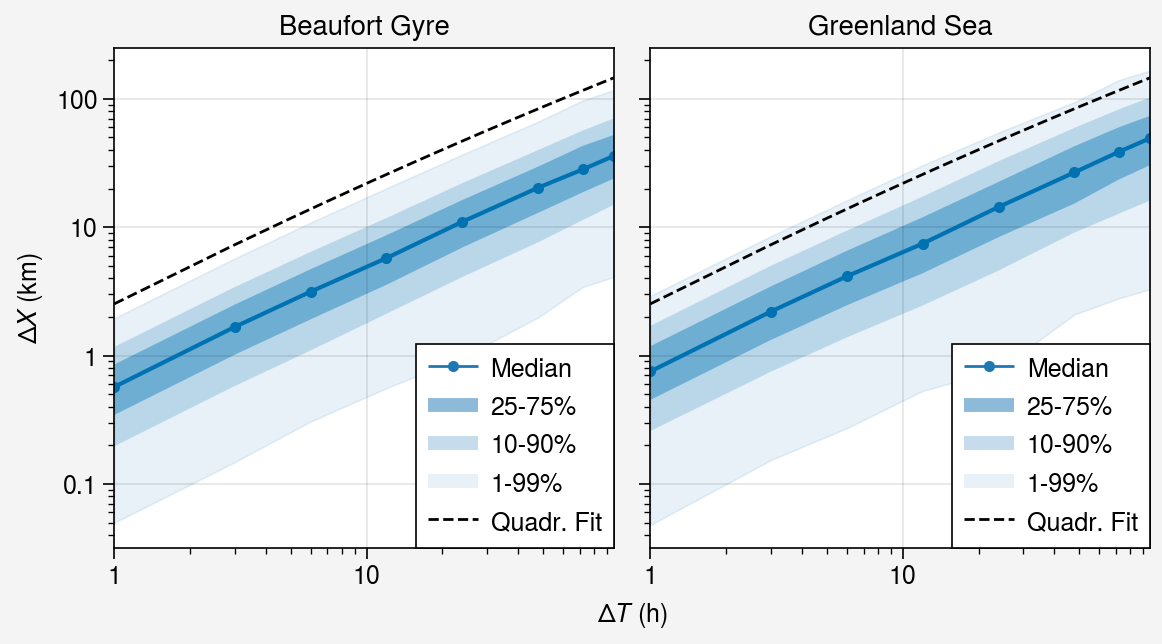

In [334]:
fig, axs = pplt.subplots(ncols=2)
for ax, plot_df in zip(axs, [plot_df_bg, plot_df_fs]):
    percentiles = ['q01', 'q25', 'median', 'q75', 'q99']
    ax.plot(plot_df['median']/1e3, marker='.', shadedata=plot_df[['q25', 'q75']].T/1e3, fadedata=plot_df[['q10', 'q90']].T/1e3, label='')
    ax.fill_between(plot_df.index, plot_df['q01']/1e3, plot_df['q99']/1e3, color='tab:blue', alpha=0.1, label='')
    
    t = np.linspace(1, 96)
    x = dist_thresh(t)
    ax.plot(t, x/1e3, color='k', lw=1, ls='--', label='Quadratic Threshold')
    
    h = [ax.plot([],[], color='tab:blue', lw=1, m='.')] + \
        [ax.plot([], [], lw=5, color='tab:blue', alpha=a) for a in [0.5, 0.25, 0.1]] + \
        [ax.plot([],[], color='k', lw=1, ls='--')]
    
    l = ['Median', '25-75%', '10-90%', '1-99%', 'Quadr. Fit']
    ax.legend(h, l, ncols=1, loc='lr', alpha=1)
    
    ax.format(ylabel=r'$\Delta X$ (km)', xlabel=r'$\Delta T$ (h)')
    ax.format(yscale='log', title='Buoy displacement by elapsed time', xscale='log')
    # fig.save('../figures/figXX_travel_distance.png', dpi=300)
axs[0].format(title='Beaufort Gyre')
axs[1].format(title='Greenland Sea')

In [335]:
for hour in results_fs:
    df = pd.concat(results_fs[hour])
    df2 = pd.concat(results_bg[hour])
    print(hour, len(df), len(df2))

1 78452 154036
3 25991 51316
6 13000 25605
12 6411 12770
24 3182 6367
48 1565 3182
72 1017 2119
96 746 1574


In [ ]:
temp = []
for hour in results:
    dfr = pd.concat(results[hour]).dropna()

    dfh = pd.DataFrame({
              'mean': dfr[['distance']].mean(),
              'q01': dfr[['distance']].quantile(0.01),                        
              'q10': dfr[['distance']].quantile(0.1),                        
              'q25': dfr[['distance']].quantile(0.25),
              'median': dfr[['distance']].median(),
              'q75': dfr[['distance']].quantile(0.75),
              'q90': dfr[['distance']].quantile(0.90),
              'q99': dfr[['distance']].quantile(0.99)})
    dfh.index = [hour]
    temp.append(dfh)
plot_df = pd.concat(temp)
plot_df.index.name = "dt"
plot_df.to_csv('../data/iabp_percentile_results.csv')

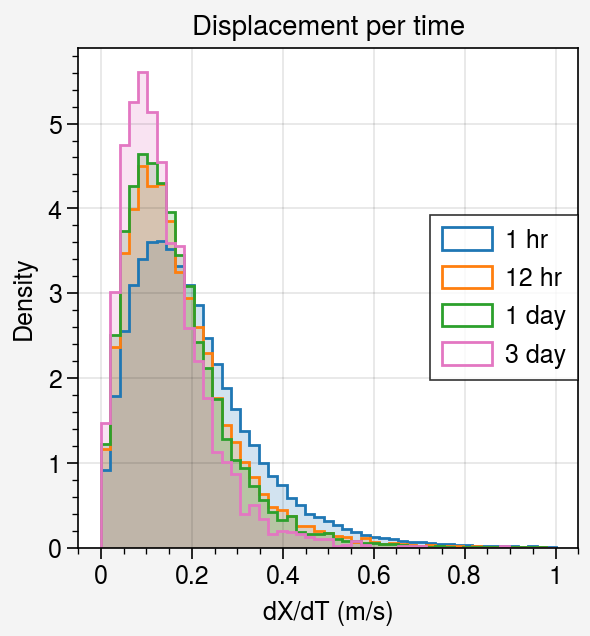

In [348]:
fig, ax = pplt.subplots()
for hours, label, color in zip([1, 12, 24, 72], ['1 hr', '12 hr', '1 day',  '3 day'], ['tab:blue', 'tab:orange', 'tab:green', 'tab:pink']):
    _ = ax.hist(pd.concat(results[hours])['distance'].dropna()/(hours * 60 * 60),
           bins=np.linspace(0, 1, 50), density=True, histtype='step', label=label, color=color, lw=1)
    _ = ax.hist(pd.concat(results[hours])['distance'].dropna()/(hours * 60 * 60),
           bins=np.linspace(0, 1, 50), density=True, histtype='stepfilled', label='', color=color, alpha=0.2)
ax.legend(ncols=1)
ax.format(xlabel='dX/dT (m/s)', title='Displacement per time', ylabel='Density')

In [342]:
from numpy.polynomial import Polynomial
polyfit_results = Polynomial.fit(np.log10(plot_df.index), np.log10(plot_df['q99']/1e3), deg=2).convert(domain=(-1, 1))

# The polyfit is done in log space.
# So for a given dt in hours, the distance in meters is:
a, b, c = np.round(polyfit_results.coef, 3)
print(a, b, c)
fitted_line = lambda x: a +  b * x + c * x**2 
dist_thresh = lambda dt: 10**fitted_line(np.log10(dt))

0.403 0.988 -0.05


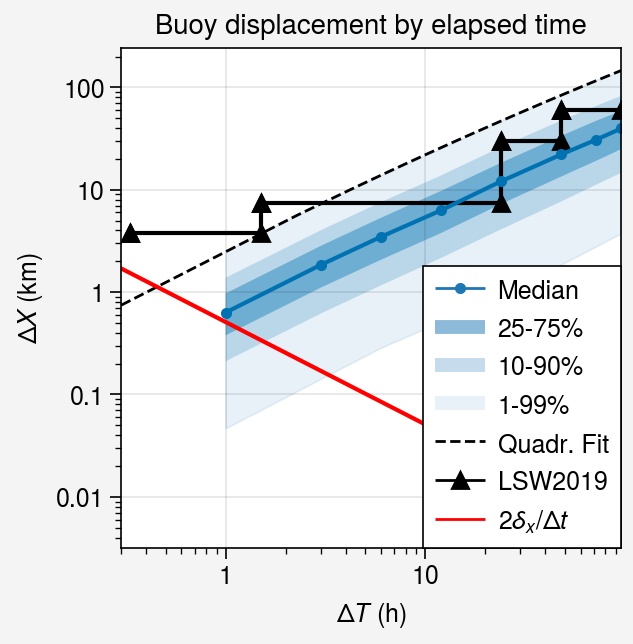

In [343]:
fig, ax = pplt.subplots()
percentiles = ['q01', 'q25', 'median', 'q75', 'q99']
ax.plot([1/3, 1.5, 1.5, 24, 24, 48, 48, 96], [3.75, 3.75, 7.5, 7.5, 30, 30, 60, 60], color='k', m='^', label='')
ax.plot([1/3, 1.5, 24, 48], [3.75, 7.5, 30, 60], color='k', m='^', lw=0, label='LSW2019')

ax.plot(plot_df['median']/1e3, marker='.', shadedata=plot_df[['q25', 'q75']].T/1e3, fadedata=plot_df[['q10', 'q90']].T/1e3, label='')
ax.fill_between(plot_df.index, plot_df['q01']/1e3, plot_df['q99']/1e3, color='tab:blue', alpha=0.1, label='')

t = np.linspace(0.3, 96)
x = dist_thresh(t)
ax.plot(t, x, color='k', lw=1, ls='--', label='Quadratic Threshold')
ax.plot(t, 255*2/1e3 / t, color='r', label='Noise Threshold')
h = [ax.plot([],[], color='tab:blue', lw=1, m='.')] + \
    [ax.plot([], [], lw=5, color='tab:blue', alpha=a) for a in [0.5, 0.25, 0.1]] + \
    [ax.plot([],[], color='k', lw=1, ls='--')] + \
    [ax.plot([],[], color='k', lw=1, ls='-', m='^'),  ax.plot([],[], color='r', lw=1, ls='-', m='')]

l = ['Median', '25-75%', '10-90%', '1-99%', 'Quadr. Fit', 'LSW2019', r'$2\delta_x / \Delta t$']
ax.legend(h, l, ncols=1, loc='lr', alpha=1)

ax.format(ylabel=r'$\Delta X$ (km)', xlabel=r'$\Delta T$ (h)')
ax.format(yscale='log', title='Buoy displacement by elapsed time', xscale='log')
fig.save('../figures/travel_distance_LSW2019_comp.png', dpi=300)

Comment: the IABP buoy does not allow us to estimate the range of displacements at 20 m intervals with confidence. The data from earlier than 2016 includes Argos buoys, which deliver position estimates in batches every approximately 3 hours, and have uncertainty around 300 m. 

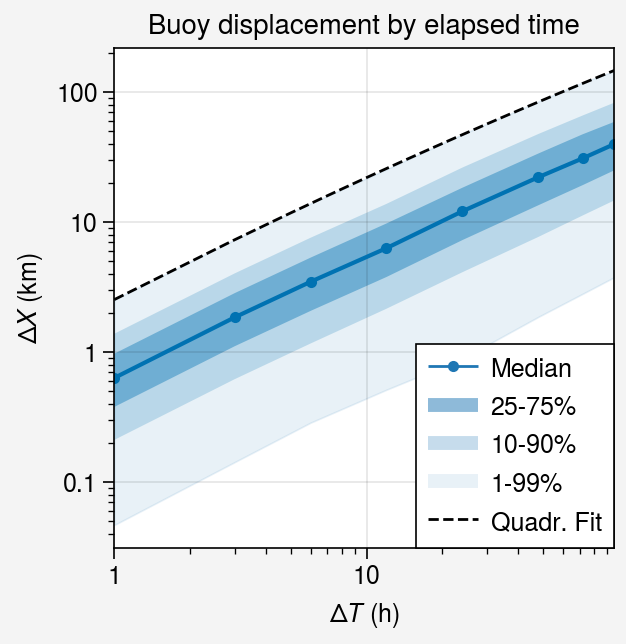

In [341]:
fig, ax = pplt.subplots()
percentiles = ['q01', 'q25', 'median', 'q75', 'q99']
ax.plot(plot_df['median']/1e3, marker='.', shadedata=plot_df[['q25', 'q75']].T/1e3, fadedata=plot_df[['q10', 'q90']].T/1e3, label='')
ax.fill_between(plot_df.index, plot_df['q01']/1e3, plot_df['q99']/1e3, color='tab:blue', alpha=0.1, label='')

t = np.linspace(1, 96)
x = dist_thresh(t)
ax.plot(t, x/1e3, color='k', lw=1, ls='--', label='Quadratic Threshold')

h = [ax.plot([],[], color='tab:blue', lw=1, m='.')] + \
    [ax.plot([], [], lw=5, color='tab:blue', alpha=a) for a in [0.5, 0.25, 0.1]] + \
    [ax.plot([],[], color='k', lw=1, ls='--')]

l = ['Median', '25-75%', '10-90%', '1-99%', 'Quadr. Fit']
ax.legend(h, l, ncols=1, loc='lr', alpha=1)

ax.format(ylabel=r'$\Delta X$ (km)', xlabel=r'$\Delta T$ (h)')
ax.format(yscale='log', title='Buoy displacement by elapsed time', xscale='log')
fig.save('../figures/fig_XX_travel_distance.png', dpi=300)